# TFIDF
- Brigitte Hogan (bwh5v@virginia.edu) & Jason Tiezzi (jbt5am@virginia.edu)  
- DS 5001: Exploratory Text Analytics
- April 2020  

<font color = gray>

## Overview

This notebook reads in `VOCAB`, `TOKEN` and `LIB` and creates 3 TFIDF tables for our corpus:  
    
   <font color = gray> 1. TFIDF with bag of Recipe (`TFIDF_recipe.csv`)  
    
   <font color = gray> 2. TFIDF with bag of Book (`TFIDF_book.csv`)  
    
   <font color = gray> 3. TFIDF with bag of Period (`TFIDF_timeperiod.csv`)   

---
# Setup

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
from nltk.stem.porter import PorterStemmer
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

## Configs

In [2]:
#os.chdir('C:/Users/Jason/Documents/Data Science/Spring 2020/Text Analytics/final_project/DS5001-Text-Analytics/')
#file_dir = 'C:/Users/Jason/Documents/Data Science/Spring 2020/Text Analytics/final_project/From_GitHub_427/'
data_dir = 'Tables/'
#os.chdir(file_dir)

## Functions

### Defining the TFIDF Function


In [3]:
def TFIDF(TOKEN, OHCO='book', count_method='n', tf_method='sum', idf_method='standard', term_type='term_str'): 

    # Specifying the term type
    TOKEN = TOKEN[~TOKEN.term_str.isna()] # removing blank term_str
    stemmer1 = PorterStemmer()
    stem = TOKEN['term_str'].apply(stemmer1.stem).to_list() # adding stems
    TOKEN.insert(len(TOKEN.columns), 'stem', stem, True) 
    #TOKEN['stem'] = TOKEN.term_str.apply(stemmer1.stem) # adding stems
    print('Term Type: ', term_type)

    
    # Specifying the bag size, customized to our text
    OHCO1 = ['period', 'book_year','book_id', 'vol_num','chap_num', 'recp_num','para_num', 'sent_num', 'token_num']
    sentence = OHCO1[:8]
    paragraph = OHCO1[:7]
    recipe = OHCO1[:6]
    chapter = OHCO1[:5]
    volume = OHCO1[:4]
    book = OHCO1[:3]
    book_year = OHCO1[:2]
    period = OHCO1[:1]
    if OHCO == 'chapter':
        bag = chapter
    elif OHCO == 'sentence':
        bag = sentence
    elif OHCO == 'paragraph':
        bag = paragraph
    elif OHCO == 'book':
        bag = book
    elif OHCO == 'recipe':
        bag = recipe
    elif OHCO == 'volume':
        bag = volume
    elif OHCO == 'period':
        bag = period
    elif OHCO == 'book_year':
        bag = book_year
    print('Bag Level: ', OHCO)

    # Creating the document-term matrix
    BOW = TOKEN.groupby(bag+[term_type]).term_str.count()\
    .to_frame().rename(columns={'term_str':'n'})
    BOW['c'] = BOW.n.astype('bool').astype('int')
    DTCM = BOW[count_method].unstack().fillna(0).astype('int')
    print('Count method: ', count_method)

    # Specifying the TF method and calculating TF
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0] 
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    print('TF method: ', tf_method)
   
    # Calculating DF and TFIDF
    DF = DTCM[DTCM > 0].count()
    N = DTCM.shape[0]
    
    if idf_method == 'standard':
        IDF = np.log10(N / DF)
    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 
    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF)) + 1 
    print('IDF method: ', idf_method)    

    TF = TF.T
    TFIDF = TF * IDF
    
    return TFIDF

### Defining the VOCAB update/merge function

In [4]:
def merge_TFIDF(VOCAB, sums, sum_type):
    s_type = 'TFIDF_sum_' + sum_type
    if s_type in VOCAB.columns:
        if VOCAB.index.name != 'term_str':
            VOCAB = VOCAB.reset_index(drop=True).set_index(['term_str'])
        VOCAB.update(sums)
    else:
        if VOCAB.index.name == 'term_str':
            VOCAB = VOCAB.reset_index()
        VOCAB = pd.merge(VOCAB, sums, on='term_str') 
    return VOCAB

---
# Calculating TFIDF for our corpus

### Reading in the data and preprocessing

In [5]:
TOKEN = pd.read_csv(data_dir + 'TOKEN.csv')

In [6]:
TOKEN.sample(20, random_state=2887)

,book_id,vol_num,chap_num,recp_num,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,term_id
1002620,54568,2,16,157.0,1,3,10,"('time', 'NN')",NN,time,time,15265.0
702288,28681,2,8,0.0,12,0,29,"('up', 'RP')",RP,up,up,15946.0
325684,9938,3,156,269.0,1,1,27,"('all', 'DT')",DT,all,all,1433.0
113804,9936,2,30,84.0,0,6,5,"(',', ',')",",",",",NaN,NaN
747960,28681,3,24,18.0,52,0,12,"('No', 'UH')",UH,No,no,10310.0
268429,9937,5,208,408.0,0,4,0,"('Besides', 'IN')",IN,Besides,besides,2269.0
1034432,54568,2,29,289.0,7,1,52,"('aside', 'RB')",RB,aside,aside,1806.0
281432,9938,1,6,19.0,0,3,14,"('serve', 'VB')",VB,serve,serve,13496.0
30538,9935,2,51,135.0,0,4,25,"('that', 'IN')",IN,that,that,15103.0
886083,28681,5,37,37.0,32,0,6,"('light', 'JJ')",JJ,light,light,9077.0


In [7]:
TOKEN.shape

(1130904, 12)

In [8]:
LIB = pd.read_csv(data_dir + 'LIB.csv')
LIB

,book_id,author_last,author_full,book_year,book_title,book_file,period
0,9935,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks/WIDAS1923_WILCV01_pg9935.txt,1900s
1,9936,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 2",Cookbooks/WIDAS1923_WILCV02_pg9936.txt,1900s
2,9937,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 3",Cookbooks/WIDAS1923_WILCV03_pg9937.txt,1900s
3,9938,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 4",Cookbooks/WIDAS1923_WILCV04_pg9938.txt,1900s
4,9939,WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 5",Cookbooks/WIDAS1923_WILCV05_pg9939.txt,1900s
5,10582,Bradley,Alice Bradley,1923,For Luncheon and Supper Guests,Cookbooks/Bradley1923_FLSG_pg10582.txt,1900s
6,12519,Randolf,Mary Randolph,1860,The Virginia Housewife,Cookbooks/Randolf1860_VAHousewife_pg12519.txt,mid1800s
7,15464,Goudiss,Alice Bradley,1918,Foods That Will Win The War And How To Cook,Cookbooks/Goudiss1918_War_pg15464.txt,1900s
8,19077,Hill,Janet McKenzie Hill,1909,"Salads, Sandwiches and Chafing - Dish Dainties",Cookbooks/Hill1909_SSCDD_pg19077.txt,1900s
9,24205,Murrey,Thomas J. Murrey,1885,Breakfast Dainties,Cookbooks/Murrey1885_Bfast_pg24205.txt,late1800s


In [9]:
VOCAB = pd.read_csv(data_dir + 'VOCAB.csv')
VOCAB.head()

,term_id,term_str,n,num,stop,stem_porter,stem_snowball,term_rank,term_rank2,p,zipf_k,zipf_k2,zipf_k3
0,15108,the,60407,0,1,the,the,1,1,3.598654,60407,60407,3.598654
1,10502,of,35149,0,1,of,of,2,2,2.093947,70298,70298,4.187895
2,1546,and,33319,0,1,and,and,3,3,1.984928,99957,99957,5.954784
3,1062,a,28726,0,1,a,a,4,4,1.711307,114904,114904,6.845228
4,8071,in,22204,0,1,in,in,5,5,1.322769,111020,111020,6.613845


### Merging in the library table since it contains the book year and period

In [10]:
TOKEN1 = pd.merge(TOKEN, LIB[['book_id', 'book_year', 'period']], on='book_id', how="inner")
TOKEN1.sample(10)

,book_id,vol_num,chap_num,recp_num,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,term_id,book_year,period
621289,19077,1,13,199.0,2,2,3,"('slightly', 'RB')",RB,slightly,slightly,13892.0,1909,1900s
757947,28681,3,25,19.0,97,1,8,"('season', 'NN')",NN,season,season,13364.0,1830,mid1800s
936947,34107,0,0,28.0,2,10,26,"('not', 'RB')",RB,not,not,10345.0,1887,late1800s
917968,29519,0,9,148.0,14,3,21,"('much', 'JJ')",JJ,much,much,10032.0,1892,late1800s
280792,9938,1,5,16.0,0,2,14,"('unimportant', 'JJ')",JJ,unimportant,unimportant,15811.0,1923,1900s
622171,19077,1,13,205.0,2,3,20,"('mould', 'NN')",NN,mould,mould,10001.0,1909,1900s
906472,29519,0,4,93.0,1,0,11,"('it', 'PRP')",PRP,it,it,8516.0,1892,late1800s
939833,34107,0,0,44.0,2,4,1,"('oz', 'NN')",NN,oz,oz,10804.0,1887,late1800s
1076285,61185,0,5,0.0,8,1,89,"('we', 'PRP')",PRP,we,we,16358.0,1877,late1800s
261136,9937,5,192,365.0,0,7,3,"('a', 'DT')",DT,a,a,1062.0,1923,1900s


---
# Applying the Function

## 1. Running the function with a bag of book

Note: I defined all of the arguments (even though it's not required by the function) just so it would be clear what specifications we used.

In [11]:
TFIDF_book = TFIDF(TOKEN=TOKEN1, OHCO='book', count_method='n', tf_method='sum', idf_method='standard', term_type='term_str') 

Term Type:  term_str
Bag Level:  book
Count method:  n
TF method:  sum
IDF method:  standard


In [12]:
TFIDF_book.sum().sort_values(ascending=False).head(30)

# looking at the top 30 words in our corpus by TFIDF -- interesting that we got some numbers in there!

term_str
12               0.010532
1                0.009640
curry            0.008969
teaspoon         0.008843
tablespoons      0.007332
tsp              0.006166
antonini         0.005320
cup              0.005207
14               0.005086
c                0.004756
p                0.004661
nelson           0.004642
tb               0.004391
smith            0.003997
metabolism       0.003850
tablespoon       0.003781
teaspoons        0.003732
syrup            0.003596
j                0.003342
4                0.003191
stuffs           0.003133
blazer           0.003121
till             0.003036
calories         0.002940
madras           0.002933
teaspoonful      0.002919
foods            0.002870
gill             0.002839
3                0.002827
tablespoonful    0.002749
dtype: float64

#### Plotting the top 10 terms

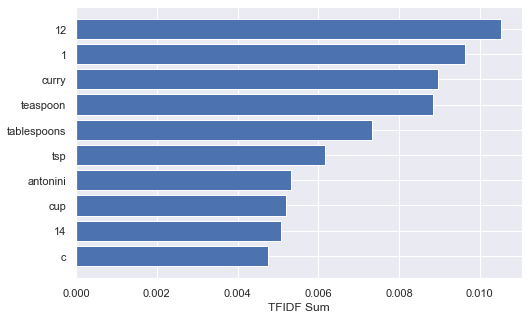

In [13]:
top10_book = TFIDF_book.sum().sort_values(ascending=False).head(10).sort_values(ascending=True)
plt.figure(figsize=(8,5))
plt.barh(y=top10_book.index, width=top10_book)
plt.xlabel("TFIDF Sum")
plt.show()

You can see that terms of measurement and numbers are all over the top 10

#### Diving a little deeper into the top 10 terms 

In [14]:
# looking at small and large terms of measurement by time period
values = TFIDF_book['teaspoon'] + TFIDF_book['tablespoon'] + TFIDF_book['tsp'] + TFIDF_book['tb']
values = pd.DataFrame(values, columns=['small_measurements']).sort_index(axis=0, level='book_year', ascending=True)
values['big_measurements'] = TFIDF_book['cup'] + TFIDF_book['c'] + TFIDF_book['gallon'] + TFIDF_book['pint'] + TFIDF_book['p']
values = values.reset_index()
values1 = values.groupby('period').mean()
values1

,book_year,book_id,small_measurements,big_measurements
period,,,,
1900s,1920.333333,14142.222222,0.002341,0.000955
late1800s,1886.888889,38346.444444,0.000235,0.000663
mid1800s,1845.000000,20600.000000,0.000000,0.000621


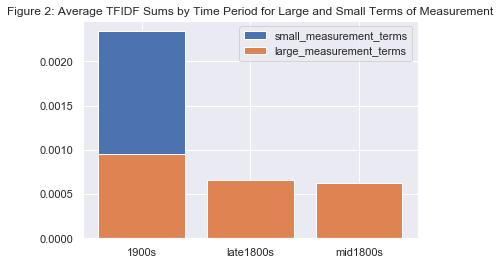

In [15]:
plt.bar(x=values1.index, height=values1.small_measurements, label="small_measurement_terms")
plt.bar(x=values1.index, height=values1.big_measurements, label = "large_measurement_terms")
plt.legend()
plt.title("Figure 2: Average TFIDF Sums by Time Period for Large and Small Terms of Measurement")
plt.show()

This chart was a little too confusing in terms of the methodology to include in the final paper (and I'm not sure TFIDF sums are the best way to represent these differences), but it does (indirectly) show how the frequency of measurement terms is far more prevalent as time passes. (Since the IDF part of the value will be the same for each word, this really shows the differences in relative term frequencies.)

In [16]:
### actually looking at tablespoon to see the invidiual breakdown by book_year [insert any other terms here if you are curious how they varied over time]
TFIDF_book[['tablespoon']]

term_str                     tablespoon
period    book_year book_id            
1900s     1909      19077      0.000000
          1918      15464      0.001175
                    32472      0.000000
          1923      9935       0.000017
                    9936       0.000004
                    9937       0.000000
                    9938       0.000008
                    9939       0.000003
                    10582      0.001463
late1800s 1877      61185      0.000000
          1884      25007      0.000000
          1885      24205      0.000037
                    24542      0.000000
          1887      34107      0.000646
          1888      53521      0.000000
          1891      38464      0.000000
          1892      29519      0.000000
          1893      54568      0.000428
mid1800s  1830      28681      0.000000
          1860      12519      0.000000

#### Merging with VOCAB table

In [17]:
# Creating TFIDF sums
sumsb = pd.DataFrame(TFIDF_book.sum(), columns=['TFIDF_sum_book'])

In [18]:
# Adding the TFIDF sums to the VOCAB table
#VOCAB = pd.merge(VOCAB, sumsb, on='term_str')
VOCAB = merge_TFIDF(VOCAB, sumsb, 'book')

In [19]:
VOCAB.head()

,term_id,term_str,n,num,stop,stem_porter,stem_snowball,term_rank,term_rank2,p,zipf_k,zipf_k2,zipf_k3,TFIDF_sum_book
0,15108,the,60407,0,1,the,the,1,1,3.598654,60407,60407,3.598654,0.0
1,10502,of,35149,0,1,of,of,2,2,2.093947,70298,70298,4.187895,0.0
2,1546,and,33319,0,1,and,and,3,3,1.984928,99957,99957,5.954784,0.0
3,1062,a,28726,0,1,a,a,4,4,1.711307,114904,114904,6.845228,0.0
4,8071,in,22204,0,1,in,in,5,5,1.322769,111020,111020,6.613845,0.0


## 2. Running TFIDF with a bag of recipe


In [20]:
TFIDF_recp = TFIDF(TOKEN=TOKEN1, OHCO='recipe', count_method='n', tf_method='sum', idf_method='standard', term_type='term_str') 

Term Type:  term_str
Bag Level:  recipe
Count method:  n
TF method:  sum
IDF method:  standard


In [21]:
TFIDF_recp.sum().sort_values(ascending=False).head(30)
# looking at TFIDF by recipe -- again, measurement terms are all over the place, although this time you are
# seeing far more in terms of food words than with book

term_str
1         25.807714
is        18.428777
cup       18.059645
it        17.931239
them      17.303845
be        16.731512
are       16.177557
c         16.170029
2         16.137305
milk      16.041030
water     15.611171
12        15.214541
as        15.057910
add       15.005058
the       14.919713
sugar     14.177607
butter    13.546018
for       13.489683
that      13.470927
cream     13.446396
of        13.203503
or        13.176509
with      13.100030
salt      13.007485
they      12.901848
a         12.451291
flour     12.357812
salad     12.221847
to        11.958100
sauce     11.916914
dtype: float64

#### Plotting the top 10 terms

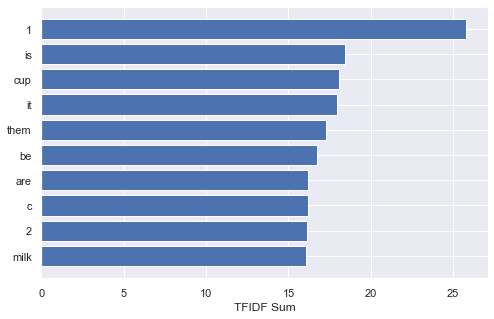

In [22]:
top10_recp = TFIDF_recp.sum().sort_values(ascending=False).head(10).sort_values(ascending=True)
plt.figure(figsize=(8,5))
plt.barh(y=top10_recp.index, width=top10_recp)
plt.xlabel("TFIDF Sum")
plt.show()

#### Adding to VOCAB table

In [23]:
# Creating TFIDF sums
sumsr = pd.DataFrame(TFIDF_recp.sum(), columns=['TFIDF_sum_recipe'])

In [24]:
# Adding the TFIDF sums for recipe to the VOCAB table
#VOCAB = pd.merge(VOCAB, sumsr, on='term_str')
VOCAB = merge_TFIDF(VOCAB, sumsr, 'recipe')

In [25]:
VOCAB.head()

,term_id,term_str,n,num,stop,stem_porter,stem_snowball,term_rank,term_rank2,p,zipf_k,zipf_k2,zipf_k3,TFIDF_sum_book,TFIDF_sum_recipe
0,15108,the,60407,0,1,the,the,1,1,3.598654,60407,60407,3.598654,0.0,14.919713
1,10502,of,35149,0,1,of,of,2,2,2.093947,70298,70298,4.187895,0.0,13.203503
2,1546,and,33319,0,1,and,and,3,3,1.984928,99957,99957,5.954784,0.0,7.244055
3,1062,a,28726,0,1,a,a,4,4,1.711307,114904,114904,6.845228,0.0,12.451291
4,8071,in,22204,0,1,in,in,5,5,1.322769,111020,111020,6.613845,0.0,9.951277


## 3. Running TFIDF with a bag of period

I think it's better to do TFIDF by book and then groupby time period, but just so we'd have it, I also ran it for the time periods directly. The obvious problem is that because there are only three time periods, any term that appears in all three will have a TFIDF of zero, meaning there probably won't be a ton of non-zero terms. 

In [26]:
TFIDF_timeperiod = TFIDF(TOKEN1, OHCO="period", count_method='n', tf_method='sum', idf_method='standard', term_type='term_str')

Term Type:  term_str
Bag Level:  period
Count method:  n
TF method:  sum
IDF method:  standard


Exploring the percentage of  of non-zero values -- and interestingly, 3/4 are non-zero. 


In [27]:
time_period_sums = TFIDF_timeperiod.sum()
len(time_period_sums[time_period_sums >0]) / len(time_period_sums)

0.7615274633623258

Looking at the top 30 terms


In [28]:
TFIDF_timeperiod.sum().sort_values(ascending=False).head(30)

term_str
tsp               0.000777
obs               0.000682
tb                0.000554
flavor            0.000335
teaspoon          0.000299
nelson            0.000291
sirup             0.000282
amount            0.000252
teaspoonful       0.000228
tablespoons       0.000191
yelks             0.000184
nb                0.000172
shown             0.000168
etc               0.000162
tablespoonful     0.000156
tablespoon        0.000149
qt                0.000145
color             0.000142
canned            0.000141
colour            0.000135
protein           0.000133
yelk              0.000132
yolks             0.000127
saltspoon         0.000122
tablespoonfuls    0.000120
tamis             0.000115
¼                 0.000109
mayonnaise        0.000108
drachm            0.000108
savoury           0.000106
dtype: float64

#### Plotting the top 10 terms

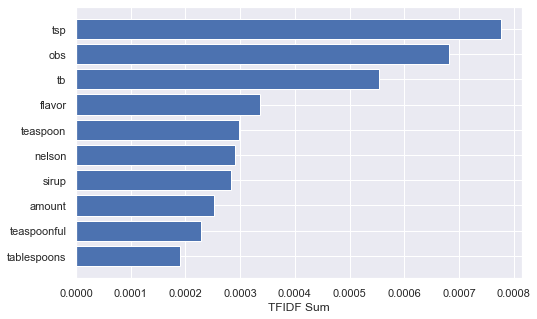

In [29]:
top10_tp = TFIDF_timeperiod.sum().sort_values(ascending=False).head(10).sort_values(ascending=True)
plt.figure(figsize=(8,5))
plt.barh(y=top10_tp.index, width=top10_tp)
plt.xlabel("TFIDF Sum")
plt.show()

Once again, terms of measurement are near the top. It seems that terms of measurements are one of the biggest differentiators, no matter what bag is used. 

#### Adding sums to the VOCAB Table

In [30]:
sumsp = pd.DataFrame(TFIDF_timeperiod.sum(), columns=['TFIDF_sum_period'])

In [31]:
# Adding the TFIDF sums for period
#VOCAB = pd.merge(VOCAB, sumsp, on='term_str')
VOCAB = merge_TFIDF(VOCAB, sumsp, 'period')

Fix issue with saving extra columns

In [32]:
if VOCAB.index.name == 'term_str':
    VOCAB = VOCAB.reset_index()

In [33]:
VOCAB.head()

,term_id,term_str,n,num,stop,stem_porter,stem_snowball,term_rank,term_rank2,p,zipf_k,zipf_k2,zipf_k3,TFIDF_sum_book,TFIDF_sum_recipe,TFIDF_sum_period
0,15108,the,60407,0,1,the,the,1,1,3.598654,60407,60407,3.598654,0.0,14.919713,0.0
1,10502,of,35149,0,1,of,of,2,2,2.093947,70298,70298,4.187895,0.0,13.203503,0.0
2,1546,and,33319,0,1,and,and,3,3,1.984928,99957,99957,5.954784,0.0,7.244055,0.0
3,1062,a,28726,0,1,a,a,4,4,1.711307,114904,114904,6.845228,0.0,12.451291,0.0
4,8071,in,22204,0,1,in,in,5,5,1.322769,111020,111020,6.613845,0.0,9.951277,0.0


---
## Adding TFIDF sums to our reduced VOCAB table too

In [34]:
VOCAB2 = pd.read_csv(data_dir + 'VOCAB2.csv')
VOCAB2.shape

(15575, 11)

In [35]:
VOCAB2.head()

,term_id,term_str,n,stem_porter,stem_snowball,term_rank,term_rank2,p,zipf_k,zipf_k2,zipf_k3
0,16338,water,4900,water,water,18,18,0.291910,88200,88200,5.254379
1,9575,may,4059,may,may,25,25,0.241809,101475,101475,6.045216
2,10570,one,3480,one,one,31,31,0.207316,107880,107880,6.426784
3,1233,add,3382,add,add,33,33,0.201477,111606,111606,6.648755
4,12135,put,3100,put,put,37,37,0.184678,114700,114700,6.833075


#### Create reduced TOKEN

In [36]:
# Add term_id to TOKEN to combine VOCAB & TOKEN tables later
TOKEN2 = TOKEN.copy()
TOKEN2['term_id'] = TOKEN.term_str.map(VOCAB2.reset_index().set_index('term_str').term_id) # using .map() because no shared index yet

In [37]:
# Adjust TOKEN table to match VOCAB
TOKEN2 = TOKEN2[~TOKEN2.term_id.isna()]

In [38]:
# Merge with LIB table
TOKEN2 = pd.merge(TOKEN2, LIB[['book_id', 'book_year', 'period']], on='book_id', how="inner")

In [39]:
TOKEN2.head()

,book_id,vol_num,chap_num,recp_num,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,term_id,book_year,period
0,9935,1,1,1.0,0,1,0,"('Without', 'IN')",IN,Without,without,16577.0,1923,1900s
1,9935,1,1,1.0,0,1,1,"('doubt', 'NN')",NN,doubt,doubt,5252.0,1923,1900s
2,9935,1,1,1.0,0,1,4,"('greatest', 'JJS')",JJS,greatest,greatest,7253.0,1923,1900s
3,9935,1,1,1.0,0,1,5,"('problem', 'NN')",NN,problem,problem,11883.0,1923,1900s
4,9935,1,1,1.0,0,1,6,"('confronting', 'VBG')",VBG,confronting,confronting,3871.0,1923,1900s


#### Create new TFIDFs from reduced TOKEN

In [40]:
# Creating TFIDF for each bag
TFIDF_book2   = TFIDF(TOKEN=TOKEN2, OHCO='book', count_method='n', tf_method='sum', idf_method='standard', term_type='term_str') 
TFIDF_recipe2 = TFIDF(TOKEN=TOKEN2, OHCO='recipe', count_method='n', tf_method='sum', idf_method='standard', term_type='term_str')
TFIDF_period2 = TFIDF(TOKEN2, OHCO="period", count_method='n', tf_method='sum', idf_method='standard', term_type='term_str')

Term Type:  term_str
Bag Level:  book
Count method:  n
TF method:  sum
IDF method:  standard
Term Type:  term_str
Bag Level:  recipe
Count method:  n
TF method:  sum
IDF method:  standard
Term Type:  term_str
Bag Level:  period
Count method:  n
TF method:  sum
IDF method:  standard


In [41]:
# Creating TFIDF sums
sumsr = pd.DataFrame(TFIDF_recp.sum(), columns=['TFIDF_sum_recipe'])
sumsb = pd.DataFrame(TFIDF_book.sum(), columns=['TFIDF_sum_book'])
sumsp = pd.DataFrame(TFIDF_timeperiod.sum(), columns=['TFIDF_sum_period'])

#### Merging with VOCAB2

In [42]:
#VOCAB2 = pd.merge(VOCAB2, sumsb, on='term_str') # adding the TFIDF sums for book
#VOCAB2 = pd.merge(VOCAB2, sumsr, on='term_str') # adding the TFIDF sums for recipe
#VOCAB2 = pd.merge(VOCAB2, sumsp, on='term_str') # adding the TFIDF sums for period
VOCAB2 = merge_TFIDF(VOCAB2, sumsb, 'book')   # adding the TFIDF sums for book
VOCAB2 = merge_TFIDF(VOCAB2, sumsr, 'recipe') # adding the TFIDF sums for recipe
VOCAB2 = merge_TFIDF(VOCAB2, sumsp, 'period') # adding the TFIDF sums for period

Fix issue with saving extra columns (works together with index=False on df.to_csv)

In [43]:
if VOCAB2.index.name == 'term_str':
    VOCAB2 = VOCAB2.reset_index()

In [44]:
VOCAB2.head()

,term_id,term_str,n,stem_porter,stem_snowball,term_rank,term_rank2,p,zipf_k,zipf_k2,zipf_k3,TFIDF_sum_book,TFIDF_sum_recipe,TFIDF_sum_period
0,16338,water,4900,water,water,18,18,0.291910,88200,88200,5.254379,0.000000,15.611171,0.0
1,9575,may,4059,may,may,25,25,0.241809,101475,101475,6.045216,0.001478,11.286535,0.0
2,10570,one,3480,one,one,31,31,0.207316,107880,107880,6.426784,0.000000,11.359557,0.0
3,1233,add,3382,add,add,33,33,0.201477,111606,111606,6.648755,0.000000,15.005058,0.0
4,12135,put,3100,put,put,37,37,0.184678,114700,114700,6.833075,0.000000,9.889675,0.0


In [45]:
VOCAB2.shape

(15575, 14)

---
# Writing to CSV

*Commented out so our files don't get overwritten*

In [46]:
#TFIDF_book.to_csv(data_dir + 'TFIDF_book.csv')
#TFIDF_recp.to_csv(data_dir + 'TFIDF_recipe.csv')
#TFIDF_timeperiod.to_csv(data_dir + 'TFIDF_period.csv')
#VOCAB.to_csv(data_dir + 'VOCAB.csv', index=False)

Reduced VOCAB

In [47]:
#TFIDF_book2.to_csv(data_dir + 'TFIDF_book2.csv')
#TFIDF_recipe2.to_csv(data_dir + 'TFIDF_recipe2.csv')
#TFIDF_period2.to_csv(data_dir + 'TFIDF_period2.csv')
#VOCAB2.to_csv(data_dir + 'VOCAB2.csv', index=False)